# Préparez des données pour un organisme de santé publique

## 0 - Rappel du sujet

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts, et fait appel aux services de votre entreprise. Cette base de données open source est mise à la disposition de particuliers, et d’organisations afin de leur permettre de connaître la qualité nutritionnelle de produits. 

Aujourd’hui, pour ajouter un produit à la base de données d'Open Food Facts, il est nécessaire de remplir de nombreux champs textuels et numériques, ce qui peut conduire à des erreurs de saisie et à des valeurs manquantes dans la base. 

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données. Dans un premier temps, vous devez vous concentrer sur la prise en main des données, et d’abord les nettoyer et les explorer.

Afin de simplifier ton approche, je te propose de commencer par établir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

Voici les différentes étapes pour nettoyer et explorer les données : 

1) Traiter le jeu de données

Repérer des variables pertinentes pour les traitements à venir, et nécessaires pour suggérer des valeurs manquantes,.
Nettoyer les données en :
mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.
Automatiser ces traitements pour éviter de répéter ces opérations
Attention, le client souhaite que le programme fonctionne si la base de données est légèrement modifiée (ajout d’entrées, par xmple) !

 

2) Tout au long de l’analyse, produire des visualisations afin de mieux comprendre les données. Effectuer une analyse univariée pour chaque variable intéressante, afin de synthétiser son comportement.

## 1 - Préparer le dataframe

In [5]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
#!pip install missingno
import missingno as msno

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2


In [6]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_3/openfoodfacts/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ] [ vegetable-oil -...,NaN,NaN,0.0,NaN,NaN,0.0,...,3.57,NaN,NaN,NaN,0.00000,0.000,NaN,0.0,NaN,NaN,NaN,NaN,0.0214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,NaN,NaN,Torn & Glasser,torn-glasser,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,NaN,NaN,NaN,NaN,28 g (0.25 cup),NaN,0.0,[ peanuts -> en:peanuts ] [ wheat-flour -> ...,NaN,NaN,0.0,NaN,NaN,0.0,...,17.86,NaN,NaN,NaN,0.63500,0.250,NaN,0.0,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.071,NaN,0.00129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,NaN,NaN,Grizzlies,grizzlies,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Organic hazelnuts, organic cashews, organic wa...",NaN,NaN,NaN,NaN,NaN,28 g (0.25 cup),NaN,0.0,[ organic-hazelnuts -> en:organic-hazelnuts ...,NaN,NaN,0.0,NaN,NaN,0.0,...,17.86,NaN,NaN,NaN,1.22428,0.482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [7]:
data.shape

(320772, 162)

In [8]:
data.dtypes

code                                           object
url                                            object
creator                                        object
created_t                                      object
created_datetime                               object
last_modified_t                                object
last_modified_datetime                         object
product_name                                   object
generic_name                                   object
quantity                                       object
packaging                                      object
packaging_tags                                 object
brands                                         object
brands_tags                                    object
categories                                     object
categories_tags                                object
categories_fr                                  object
origins                                        object
origins_tags                

In [9]:
data.describe()

,no_nutriments,additives_n,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,nutrition_grade_uk,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,...,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
count,0.0,248939.000000,248939.000000,0.0,248939.000000,0.0,0.0,2.611130e+05,857.000000,243891.000000,229554.000000,0.0,0.0,1.0,2.000000,4.000000,1.0,1.0,1.0,24.000000,23.000000,0.0,0.0,1.0,0.0,22823.000000,22859.000000,841.000000,186.000000,38.000000,78.000000,188.000000,149.000000,8.000000,24.000000,23.000000,21.000000,13.000000,0.0,1.400000e+01,0.0,0.0,0.0,143298.000000,144090.000000,243588.000000,244971.000000,72.000000,26.000000,38.000000,...,259922.000000,27.000000,16.000000,9.000000,255510.000000,255463.000000,4133.000000,137554.000000,34.000000,7057.000000,1340.000000,918.000000,140867.000000,11154.000000,10815.000000,11729.000000,6784.000000,5240.000000,3042.000000,5.300000e+03,330.000000,2483.000000,38.000000,81.000000,24748.000000,158.000000,141050.000000,5845.000000,140462.000000,6253.000000,3929.000000,2106.000000,1620.000000,79.000000,1168.000000,20.000000,11.000000,259.000000,78.000000,29.000000,49.000000,3036.000000,165.000000,948.000000,0.0,268.000000,221210.000000,221210.000000,0.0,0.0
mean,NaN,1.936024,0.019659,NaN,0.055246,NaN,NaN,1.141915e+03,585.501214,12.730379,5.129932,NaN,NaN,7.4,6.040000,36.136182,18.9,8.1,3.0,10.752667,10.673913,NaN,NaN,61.0,NaN,10.425055,6.312493,3.182103,2.250285,3.186553,1.635462,16.229144,3.823819,0.057000,0.153842,0.061567,40.192857,25.123077,NaN,1.357143e-06,NaN,NaN,NaN,0.073476,0.020071,32.073981,16.003484,11.841667,2.878846,25.897368,...,7.075940,4.658148,2.506250,0.021678,2.028624,0.798815,7.838105,0.000397,0.518715,0.000008,0.056705,0.034219,0.023367,0.325574,0.259007,0.020303,0.023378,0.006898,0.205856,8.938696e-05,0.121290,0.072138,0.013123,0.119052,0.424635,0.092638,0.125163,0.617282,0.003652,0.534143,0.007950,0.025794,0.003014,0.012161,0.003126,0.001690,0.000401,0.000427,1.594563,0.145762,6.425698,31.458587,15.412121,49.547785,NaN,341.700764,9.165535,9.058049,NaN,NaN
std,NaN,2.502019,0.140524,NaN,0.269207,NaN,NaN,6.447154e+03,712.809943,17.578747,8.014238,NaN,NaN,NaN,0.226274,24.101433,NaN,NaN,NaN,4.019993,3.379647,NaN,NaN,NaN,NaN,17.076167,10.832591,5.607988,7.971418,13.927752,1.978192,17.512632,6.494183,0.025534,0.029160,0.010597,25.175674,26.010496,NaN,4.972452e-07,NaN,NaN,NaN,1.540223,0.358062,29.731719,22.327284,13.993859,

## 2 - Nettoyer et filtrer des features et produits

- Identifier ma cible selon les critères demandés.
- Mettres en place un processus clair et automatisé pour filtrer les features (variables / colonnes) et des produits (lignes) qui seront utilisés pour atteindre l’objectif de mon projet.

**Lister l’ensemble des features du fichier, quantitatives (numériques) ou qualitatives (catégorielles).**

In [12]:
features = data.columns
for feature in features:
    print(feature)

code
url
creator
created_t
created_datetime
last_modified_t
last_modified_datetime
product_name
generic_name
quantity
packaging
packaging_tags
brands
brands_tags
categories
categories_tags
categories_fr
origins
origins_tags
manufacturing_places
manufacturing_places_tags
labels
labels_tags
labels_fr
emb_codes
emb_codes_tags
first_packaging_code_geo
cities
cities_tags
purchase_places
stores
countries
countries_tags
countries_fr
ingredients_text
allergens
allergens_fr
traces
traces_tags
traces_fr
serving_size
no_nutriments
additives_n
additives
additives_tags
additives_fr
ingredients_from_palm_oil_n
ingredients_from_palm_oil
ingredients_from_palm_oil_tags
ingredients_that_may_be_from_palm_oil_n
ingredients_that_may_be_from_palm_oil
ingredients_that_may_be_from_palm_oil_tags
nutrition_grade_uk
nutrition_grade_fr
pnns_groups_1
pnns_groups_2
states
states_tags
states_fr
main_category
main_category_fr
image_url
image_small_url
energy_100g
energy-from-fat_100g
fat_100g
saturated-fat_100g
butyr

**Choisir une cible (une feature ayant moins de 50% de valeurs présentes) catégorielle sera très probablement plus simple à gérer qu’une quantitative dans ce projet.**

In [14]:
list_sort = data.isna().mean().sort_values()
list_sort

last_modified_t                               0.000000
last_modified_datetime                        0.000000
creator                                       0.000006
created_t                                     0.000009
created_datetime                              0.000028
code                                          0.000072
url                                           0.000072
states                                        0.000143
states_tags                                   0.000143
states_fr                                     0.000143
countries_fr                                  0.000873
countries                                     0.000873
countries_tags                                0.000873
product_name                                  0.055373
brands                                        0.088574
brands_tags                                   0.088599
energy_100g                                   0.185986
proteins_100g                                 0.189699
salt_100g 

In [15]:
#msno.bar(data)

In [16]:
# Filtrer les lignes où 'pnns_groups_1' n'est pas NaN
filtered_data = data[~data['pnns_groups_1'].isna()]

# Extraire la colonne 'pnns_groups_1' des lignes filtrées
list_pnns_groups_1 = filtered_data['pnns_groups_1'].unique()

print("Liste des valeurs :", list_pnns_groups_1)
print("Nombre de lignes :", list_pnns_groups_1.size)

Liste des valeurs : ['unknown' 'Fruits and vegetables' 'Sugary snacks' 'Cereals and potatoes'
 'Composite foods' 'Fish Meat Eggs' 'Beverages' 'Fat and sauces'
 'fruits-and-vegetables' 'Milk and dairy products' 'Salty snacks'
 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']
Nombre de lignes : 14


La variable "pnns_groups_1" me paraît être une bonne cible : il y a 14 valeurs possibles. Elle a 71 % de valeurs manquantes.

Par contre il y a des doublons, par exemple 'Cereals and potatoes' et 'cereals-and-potatoes', à corriger.

In [18]:
mask = data['pnns_groups_1'] == 'cereals-and-potatoes'
data.loc[mask, 'pnns_groups_1'] = 'Cereals and potatoes'

mask = data['pnns_groups_1'] == 'salty-snacks'
data.loc[mask, 'pnns_groups_1'] = 'Salty snacks'

mask = data['pnns_groups_1'] == 'fruits-and-vegetables'
data.loc[mask, 'pnns_groups_1'] = 'Fruits and vegetables'

mask = data['pnns_groups_1'] == 'sugary-snacks'
data.loc[mask, 'pnns_groups_1'] = 'Sugary snacks'

data.shape

(320772, 162)

**Supprimer les lignes (produits) n’ayant pas de valeur cible.**

Mettre Nan pour les produits avec la valeur 'unknown'

In [22]:
mask = data['pnns_groups_1'] == 'unknown'
print('nombre de produits à supprimer avec la valeur "unknow":', data.loc[mask].shape[0])
# mettre la valeur Nan pour la variable cible des produits avec la valeur 'unknown'
data.loc[mask, 'pnns_groups_1'] = pd.NA
data.shape

nombre de produits à supprimer avec la valeur "unknow": 22624


(320772, 162)

In [24]:
df = data[~data['pnns_groups_1'].isna()].copy()
df.shape

(68889, 162)

**Supprimer les produits en double.**

Un doublon est un produit dont le nom du produit (product name) est identique.

In [26]:
# on ajoute une colonne pour indiquer le nombre de valeurs absentes
df['NB_NAN'] = df.isna().sum(axis=1)
# on trie sur le nbre de valeurs absentes
df = df.sort_values('NB_NAN')
# on conserve la ligne doublée qui a le moins de valeurs absentes
df = df.drop_duplicates('product_name', keep='first')
# on supprime la colonne inutile pour la suite
df = df.drop('NB_NAN', axis=1)

In [28]:
df.shape

(55448, 162)

**Afficher les taux de remplissage des features du dataset.**

In [30]:
list_sort = df.isna().mean().sort_values()
list_sort

code                                          0.000000
states                                        0.000000
states_tags                                   0.000000
states_fr                                     0.000000
main_category                                 0.000000
main_category_fr                              0.000000
categories_fr                                 0.000000
categories_tags                               0.000000
pnns_groups_2                                 0.000000
categories                                    0.000000
pnns_groups_1                                 0.000000
url                                           0.000000
creator                                       0.000000
created_t                                     0.000000
last_modified_datetime                        0.000000
last_modified_t                               0.000000
created_datetime                              0.000018
product_name                                  0.000018
countries 

**Sélectionner des features qui sont assez remplis (plus que 50%) et qui vous paraissent intéressantes pour effectuer la prédiction de votre cible.**

In [32]:
features = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']
X = df[features]
X.shape

(55448, 10)

Voici les features qui me semblent intéressantes pour la prédiction de la cible :
- energy_100g
- proteins_100g
- fat_100g
- carbohydrates_100g
- salt_100g
- sodium_100g
- sugars_100g
- saturated-fat_100g
- fiber_100g
- nutrition_grade_fr

**Séparer la cible du reste du dataset.**

In [36]:
y = df['pnns_groups_1']
df = df.drop('pnns_groups_1', axis=1)
y.shape

(55448,)

In [38]:
df.shape

(55448, 161)

In [40]:
# msno.heatmap(df_features)

**Automatiser tout ce qui a été fait jusqu’à maintenant en utilisant :**
- une fonction qui prend en input votre dataframe d’origine
- les méthodes spécifiques aux dataframes pandas. Accessoirement numpy si ce que vous voulez faire n’est pas directement ou simplement disponible via la librairie pandas.

In [155]:
def clean_and_filter(df):
    # choisir la variable cible
    cible = 'pnns_groups_1'

    # nettoyer les catégories de la variable cible
    mask = df[cible] == 'cereals-and-potatoes'
    df.loc[mask, cible] = 'Cereals and potatoes'
    
    mask = df[cible] == 'salty-snacks'
    df.loc[mask, cible] = 'Salty snacks'
    
    mask = df[cible] == 'fruits-and-vegetables'
    df.loc[mask, cible] = 'Fruits and vegetables'
    
    mask = df[cible] == 'sugary-snacks'
    df.loc[mask, cible] = 'Sugary snacks'

    # mettre la valeur Nan pour la variable cible des produits avec la valeur 'unknown'
    mask = df[cible] == 'unknown'
    df.loc[mask, cible] = pd.NA
    
    # supprimer les lignes (produits) n’ayant pas de valeur cible.
    df = df[~df[cible].isna()].copy()

    # Supprimer les produits en double. Un doublon est un produit dont le nom du produit (product name) est identique.
    # on ajoute une colonne pour indiquer le nombre de valeurs absentes
    df['NB_NAN'] = df.isna().sum(axis=1)
    # on trie sur le nbre de valeurs absentes
    df = df.sort_values('NB_NAN')
    # on conserve la ligne doublée qui a le moins de valeurs absentes
    df = df.drop_duplicates('product_name', keep='first')
    # on supprime la colonne inutile pour la suite
    df = df.drop('NB_NAN', axis=1)

    # choisir les features
    features = ['energy_100g', 'proteins_100g', 'fat_100g', 'carbohydrates_100g', 'salt_100g', 'sodium_100g', 'sugars_100g', 'saturated-fat_100g', 'fiber_100g', 'nutrition_grade_fr']
    X = df[features]

    # séparer la cible du reste du dataset
    y = df[cible]

    # supprimer la cible du dataset
    df = df.drop(cible, axis=1)
    
    # retourner le résultat y (cible) et X (features)
    return y, X, df
    

In [157]:
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_3/openfoodfacts/fr.openfoodfacts.org.products.csv", sep='\t', low_memory=False)
y, X, df = clean_and_filter(data)

In [161]:
X.shape

(55448, 10)

In [163]:
y.shape

(55448,)

In [165]:
y.unique()

array(['Beverages', 'Milk and dairy products', 'Cereals and potatoes',
       'Sugary snacks', 'Composite foods', 'Salty snacks',
       'Fat and sauces', 'Fruits and vegetables', 'Fish Meat Eggs'],
      dtype=object)

In [158]:
df.shape

(55448, 161)

## 2 - Identifier et traiter les valeurs aberrantes

### 2.1 - vue globale

In [167]:
X.describe()

,energy_100g,proteins_100g,fat_100g,carbohydrates_100g,salt_100g,sodium_100g,sugars_100g,saturated-fat_100g,fiber_100g
count,45232.000000,44856.000000,43600.000000,43252.000000,42834.000000,42829.000000,42697.000000,42539.000000,27540.000000
mean,1093.322382,7.521530,13.334425,27.879683,0.880374,0.346641,13.236862,5.478628,2.728282
std,801.645883,7.211233,17.001147,27.325184,2.811570,1.106870,18.511508,8.402184,3.870259
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100000,0.000000,0.000000
25%,389.000000,1.700000,1.200000,4.400000,0.070000,0.027559,1.100000,0.300000,0.400000
50%,995.000000,6.000000,6.600000,14.500000,0.500000,0.196850,4.300000,2.000000,1.700000
75%,1652.000000,10.600000,21.600000,53.300000,1.200000,0.472441,17.000000,7.700000,3.500000
max,22000.000000,86.000000,380.000000,190.000000,297.600000,117.165354,100.000000,210.000000,86.200000


Sans entrer dans le détail, on constate déjà des valeurs aberrantes:
- Les valeurs max ne devraient pas dépasser 100 grammes (sauf "energy_100g"). Or toutes les features ont une valeur max > 100g (exemple fat max = 380g)
- Les valeurs min ne peuvent pas être négatives. Or pour la feature "sugars_100g", il y a au moins une valeur négative.


### 2.2 - Feature "energy_100g"

D'après le site internet informationsnutritionnelles.fr (lien : https://informationsnutritionnelles.fr/energie-kilojoules ), on trouve de produits pour 100 g d'aliment qui dépasse les 4 000 kj :

- Caramel et Noisettes extra gourmand (Milka) 9770 kJ- 
Black Soy Drink( Vitaso)y	6930 kJ

La valeur 0 n'est pas une valeur aberrante, car l'eau naturelle a une énergie de 0 kj
e

**Visualiser la distribution de la variable**

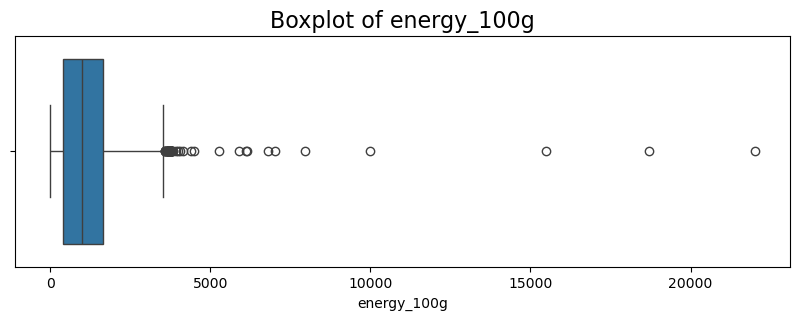

In [63]:
plt.figure(figsize=(10,3))
sns.boxplot(x=X['energy_100g'])
plt.title('Boxplot of energy_100g', fontsize=16)
plt.show()

On constate que la plupart des outliers de droite sur la boxplot sont des valeurs aberrantes. La boxplot est fortement concentrée à gauche (asymétrie à droite), qui sera confirmé dans l'histogramme ci-dessous.

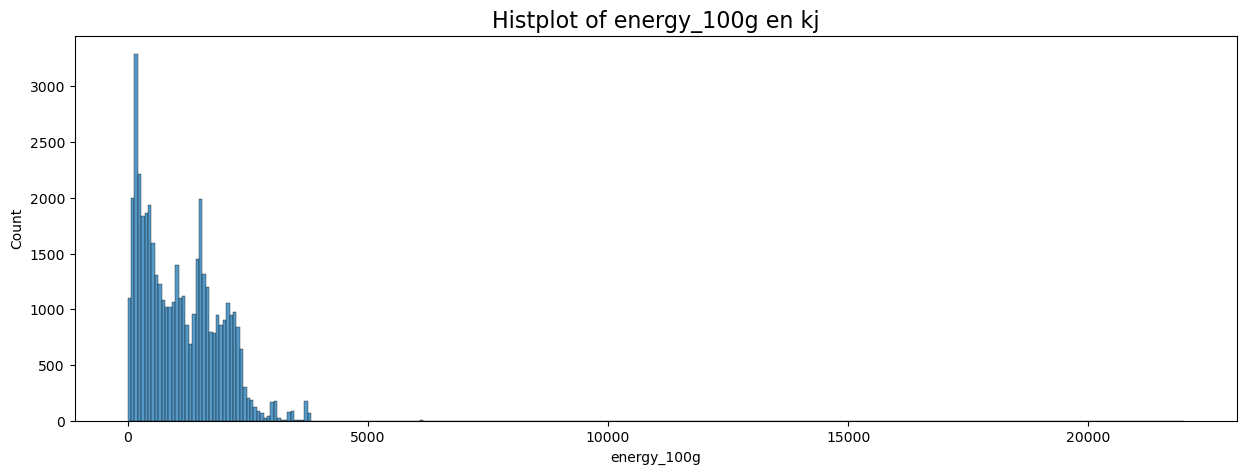

In [114]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='energy_100g')
plt.title('Histplot of energy_100g en kj', fontsize=16)
plt.show()

La concentration (étalement/asymétrie à droite) est confirmée dans cette visualisation. 

On constate la présence de 2 pics, signe d'une distribution unimodale. Le plus grand proche de 0 0k, et le 2ème proche de 1400 kj. La présence de ces 2 pics est peut-être liée à des groupes sous-jacents. On peut regarder ce qui se passe si on utilise la variable 'nutrition_grade_fr'.

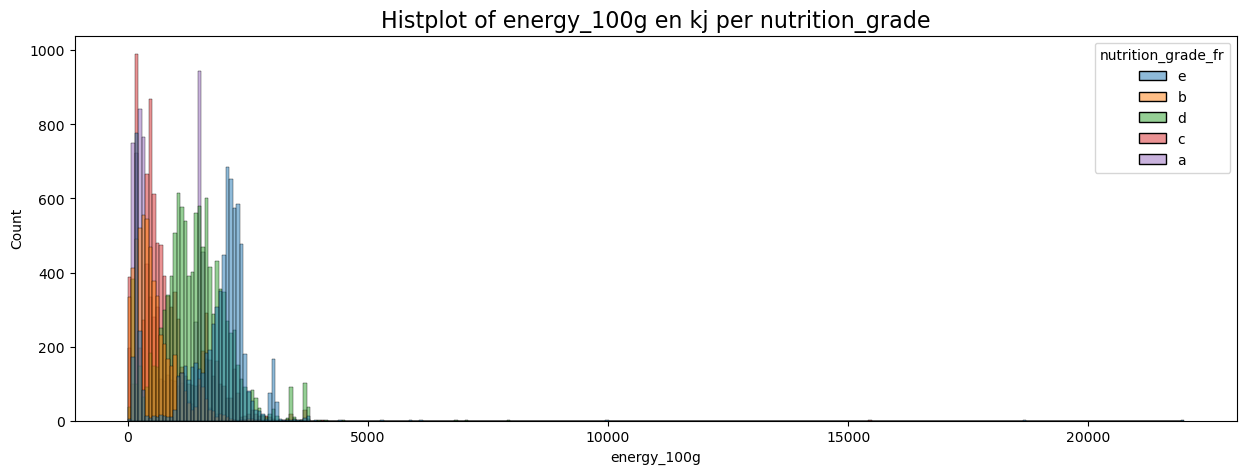

In [119]:
plt.figure(figsize=(15,5))
sns.histplot(data=X, x='energy_100g', hue='nutrition_grade_fr')
plt.title('Histplot of energy_100g en kj per nutrition_grade', fontsize=16)
plt.show()

**Calculer les limites IQR**

On peut aussi regarder la méthode basée sur l'IQR. L'IQR est la différence entre le 25e centile (Q1) et le 75e centile (Q3) des données. Les valeurs :
- inférieures à Q1 - 1,5 * IQR
- ou supérieures à Q3 + 1,5 * IQR

sont considérées comme aberrantes.

In [105]:
# On calcule l'IQR (intervalle interquartile)
Q1 = X['energy_100g'].quantile(0.25)
Q3 = X['energy_100g'].quantile(0.75)
IQR = Q3 - Q1

# On calcule les limites
limite_basse = max(0, Q1 - 1.5 * IQR)
limite_haute = Q3 + 1.5 * IQR

print("limite basse :", limite_basse, "kj")
print("limite haute :", limite_haute, "kj")

limite basse : 0 kj
limite haute : 3546.5 kj


In [169]:
mask = df['energy_100g'] > limite_haute
print(df.loc[mask, ['code', 'product_name', 'energy_100g']].sort_values(['energy_100g'], ascending=[False]))

                 code                                       product_name  \
176697  2000000045489                                             bubbly   
245311  3596710288755         mini choux goût fromage de chèvre - poivre   
223318  3291960006127  Huiles vierge biologique de Colza - première p...   
178787       20233679                                 Halva with Almonds   
311783  8480017111852                       Chocolate negro sin azúcares   
...               ...                                                ...   
153710  0822078961003                              Huile de Noix de Coco   
264638  4260168150467                                Cocofin aus Kokosöl   
62542   0051500255483                                      Crisco Blends   
19654   0022506135635                                 Virgin coconut oil   
193954  3103220035559                                Les Schtroumpfs P!k   

        energy_100g  
176697      22000.0  
245311      18700.0  
223318      15481.0  

Il y a 272 produits au delà de la limite haute (3546 kj). Mais d'après le site, il existe de très nombreux produits alimentaires qui dépassent cette limite haute, jusqu'à 3 772 kj.

**Calculer le z-score**

Utilisez la méthode du z-score Le z-score mesure de combien d'écarts types une valeur est éloignée de la moyenne de la variable. On considère qu'un z-score supérieur à 2 ou 3 correspond à un outlier.

In [171]:
# On enlève les NaN
sample = df[df['energy_100g'].notnull()].copy()

# Calculer le z-score
sample['z_energy'] = stats.zscore(sample['energy_100g'])
sample.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,...,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,z_energy
190666,3041090070198,http://world-fr.openfoodfacts.org/produit/3041...,loverock,1483100156,2016-12-30T12:15:56Z,1483101510,2016-12-30T12:38:30Z,Blédilait croissance vanille,Lait de suite et aliment lacté liquide pour en...,500ml,"bouteille,plastique","bouteille,plastique","Blédina,Blédilait,Danone","bledina,bledilait,danone","Laits pour bébé,Laits de croissance,Laits arom...","en:beverages,en:dairies,en:dairy-drinks,en:bab...","Boissons,Produits laitiers,Boissons lactées,Al...",NaN,NaN,NaN,NaN,Arômes naturels,en:natural-flavors,Arômes naturels,FR 59.580.030 EC,fr-59-580-030-ec,"50.8,2.583333",NaN,steenvoorde-nord-france,"chalon-sur-saône,france",Intermarché,France,en:france,France,"_lait_ écrémé, eau, lactose (_lait_), matières...","lait, lait, soja, soja",NaN,NaN,NaN,NaN,NaN,NaN,9.0,[ lait-ecreme -> fr:lait-ecreme ] [ lait ->...,"en:e322,en:e306,en:e300,en:e101,en:e333,en:e50...","E322 - Lécithines,E306 - Extrait riche en toco...",1.0,NaN,huile-de-palme,0.0,...,1.4,0.4,NaN,0.07366,0.029000,NaN,0.000063,NaN,1.300000e-06,0.0007,0.000009,0.0082,0.000060,0.00020,0.0008,0.000070,0.000016,NaN,3.000000e-07,0.000004,0.00050,NaN,NaN,0.095,0.045,0.0710,0.050,0.0012,0.0075,0.00060,0.000025,0.000015,0.000015,7.000000e-07,NaN,NaN,0.000015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,1.0,NaN,NaN,-1.043268
197596,3176571194008,http://world-fr.openfoodfacts.org/produit/3176...,openfoodfacts-contributors,1473964958,2016-09-15T18:42:38Z,1483894471,2017-01-08T16:54:31Z,baby croissance 3,Lait de suite pour nourrissons et aliment lact...,1L,"bouteille,plastique","bouteille,plastique","candia,Candia Baby,Sodiaal","candia,candia-baby,sodiaal","Produits laitiers,Laits,Aliments pour bébé,Lai...","en:dairies,en:milks,en:baby-foods,en:baby-milk...","Produits laitiers,Laits,Aliments pour bébé,Lai...",NaN,NaN,France,france,Sans huile de palme,en:palm-oil-free,Sans huile de palme,FR 59.039.030 EC,fr-59-039-030-ec,"50.15,3.283333",NaN,awoingt-nord-france,"Chalon-sur-saône,France","Intermarché,Leclerc",France,en:france,France,"_Lait_ partiellement écrémé, eau, _lactose_, m...","Lait, lactose",NaN,NaN,NaN,NaN,NaN,NaN,8.0,[ lait-partiellement-ecreme -> fr:lait-partie...,"en:e101,en:e300,en:e306,en:e333,en:e331,en:e51...","E101 - Riboflavine,E300 - Acide ascorbique,E30...",0.0,NaN,NaN,1.0,...,NaN,NaN,NaN,0.07620,0.030000,NaN,0.000075,NaN,1.500000e-06,0.0012,0.000004,0.0090,0.000090,0.00019,0.0007,0.000080,0.000015,NaN,2.000000e-07,0.000003,0.00050,NaN,NaN,0.095,0.052,0.0830,0.055,0.0012,0.0070,0.00080,0.0000

In [177]:
mask = sample['z_energy'] > 3
print(sample.loc[mask, ['product_name', 'energy_100g', 'z_energy']].sort_values(['energy_100g'], ascending=[False]))

                                             product_name  energy_100g  \
176697                                             bubbly      22000.0   
245311         mini choux goût fromage de chèvre - poivre      18700.0   
223318  Huiles vierge biologique de Colza - première p...      15481.0   
178787                                 Halva with Almonds       9983.0   
311783                       Chocolate negro sin azúcares       7966.0   
...                                                   ...          ...   
62542                                       Crisco Blends       3590.0   
193954                                Les Schtroumpfs P!k       3573.0   
254692                                 Virgin Coconut Oil       3515.0   
306833                                  Saveur provençale       3510.0   
217959                                Huile Vierge De Lin       3502.0   

         z_energy  
176697  26.079980  
245311  21.963404  
223318  17.947871  
178787  11.089405  
311783   8.

Le calcul du z-score n'est pas non plus pertinent ici. Les produits entre 3 800 kj et 3 500 kj n'ont pas forcément des valeurs aberrantes. On retrouve sensiblement le même nombre de produits.

Je propose de m'appuyer sur le site internet, indiqué plus haut, et déterminer que les valeurs aberrantes se situent au-dessus de 4 000 kj.

## 3 - Identifier et traiter les valeurs manquantes

valeurs aberrantes --> NaN

Vérifier les lignes produits qui ont plus de 80% de valeurs manquantes, et les supprimer.

- 0
- mediane, par groupe possible (genre groupe nutriscore)
- iterative inputer (variables corrélées entre elles)
- knn

## 4 - Effectuer les analyses uni-variées et bi-variées

## 5 - Réaliser une analyse multi-variée

## 6 - RGPD